<a href="https://colab.research.google.com/github/GenAIUnplugged/pytorch/blob/main/pytorch_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
(700, 2) (700,) (300, 2) (300,)
Loss: 0.6827
Loss: 0.2141
Loss: 0.0249
Loss: 0.0445
Loss: 0.0289
Loss: 0.1871
Loss: 0.0317
Loss: 0.0666
Loss: 0.0300
Loss: 0.1835
Loss: 0.0189
Loss: 0.0310
Loss: 0.1798
Loss: 0.2138
Loss: 0.0997
Loss: 0.0193
Loss: 0.0289
Loss: 0.0417
Loss: 0.0204
Loss: 0.1745
Loss: 0.0767
Loss: 0.0705
Loss: 0.0276
Loss: 0.1069
Loss: 0.0780
Loss: 0.0334
Loss: 0.1441
Loss: 0.0620
Loss: 0.0369
Loss: 0.1087

Start Testing...
Accuracy=95.0
test_loss:0.1334


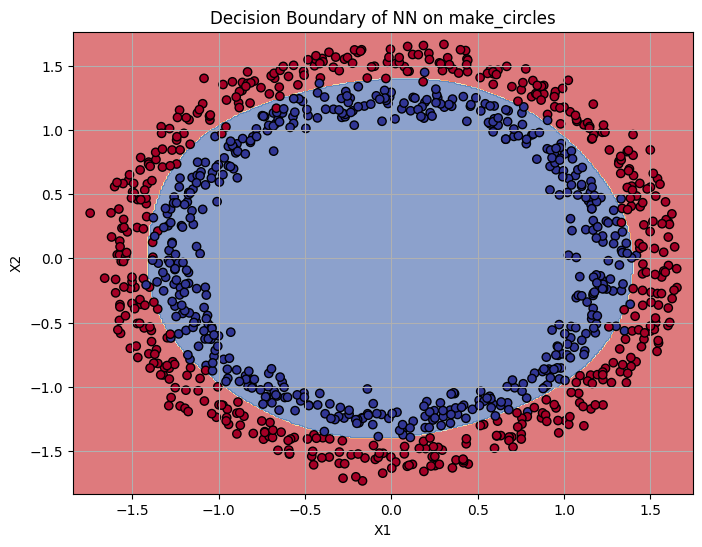

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import torch.nn as nn
from sklearn.preprocessing import StandardScaler


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

torch.manual_seed(42)

# Generate circular data with low noise
X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 10),
            nn.Tanh(),
            nn.Linear(10, 5),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.net(x)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model = NN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=1e-5)

# One training step
for epoch in range(300):
    model.train()
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print(f"Loss: {loss.item():.4f}")

model.eval()
with torch.inference_mode():
    test_loss = 0
    total_test_loss = 0
    correct = 0
    total = 0
    print("\nStart Testing...")
    for xt,yt in test_loader:
        output = model(xt)
        preds = (output>0.5).float()
        correct += (preds == yt).sum().item()
        total += yt.size(0)
        test_loss = criterion(output,yt)
        total_test_loss+=test_loss.item()

    avg_test_loss = total_test_loss/len(test_loader)
    accuracy = correct/total*100
    print(f"Accuracy={accuracy}")
    print(f'test_loss:{avg_test_loss:.4f}')



# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Create a mesh grid over the input feature space
h = 0.01  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 2: Prepare grid for model prediction
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

# Step 3: Predict using the model
model.eval()
with torch.inference_mode():
    pred_probs = model(grid_tensor)
    preds = (pred_probs > 0.5).float().cpu().numpy()

# Step 4: Plot the decision boundary
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, preds.reshape(xx.shape), cmap="RdYlBu", alpha=0.6)

# Step 5: Overlay training data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu", edgecolors="k")
plt.title("Decision Boundary of NN on make_circles")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()



